In [1]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=False)  # render_mode="rgb_array"
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v3>>>>>

In [2]:
obs, info = env.reset()

In [5]:
path_to_data = "../data/frames"
frame_stack = 4
frame_skip = 4  # Skip every 4 steps
frame_pred = 6  # Predict frame 6 steps in the future

X = []
y = []

for file in os.listdir(path_to_data):
    frames = np.load(os.path.join(path_to_data, file))
    
    # Ignore first 50 frames
    for i in range(50, frames.shape[0] - frame_pred * frame_skip):
        X.append([frames[i + j * frame_skip] for j in range(frame_stack)])
        y.append(frames[i + frame_pred * frame_skip])
        
X = np.array(X)
X = X[:, :, :84, 6:90, :]
y = np.array(y)
y = y[:, :84, 6:90, :]

X.shape, y.shape

((26852, 4, 84, 84, 3), (26852, 84, 84, 3))

14430


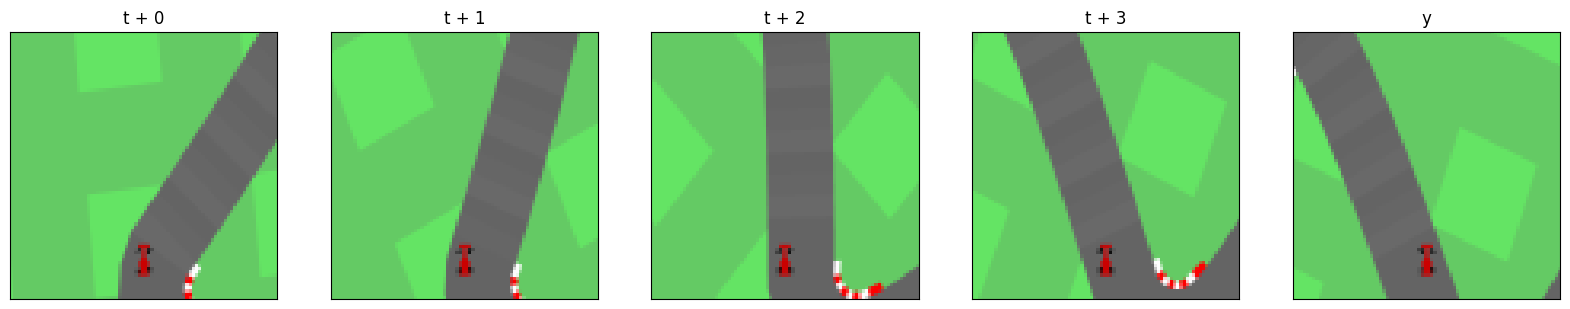

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

idx = np.random.randint(X.shape[0])
print(idx)

for i, ax in enumerate(axs[:-1]):
    ax.imshow(X[idx, i, :, :, :])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t + {i}")

ax = axs[-1]
ax.imshow(y[idx])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("y")

plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Move channel dim
# (B, T, H, W, C) -> (B, T, C, H, W)
# X = np.moveaxis(X, 4, 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Training

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF


print(torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))

True
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4095MB, multi_processor_count=14, uuid=05ab3d70-ba04-d3db-3362-a62e271d984d, L2_cache_size=1MB)


In [13]:
class FramesDataset(Dataset):
    """Image dataset.
    """

    def __init__(self, frames_in, frame_out):
        self.frames_in = frames_in
        self.frame_out = frame_out
        self.num_frames = self.frames_in.shape[1]

    def __len__(self):
        return len(self.frames_in)

    def __getitem__(self, index):
        
        x = torch.stack([TF.to_tensor(self.frames_in[index][i]) for i in range(self.num_frames)], 0)
        y = TF.to_tensor(self.frame_out[index])
        return x, y
    

def train(model, train_loader, val_loader, loss_fn,
         num_epochs=10, learning_rate=1e-4,
         early_stopping={'patience': 5, 'min_delta': 0.0001}):
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, min_lr=1e-6)

    loss_history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    print(f"Using device: {device}")
    
    total_batches = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        for i, (x, y) in enumerate(train_loader):
            
            print(f"Batch {i+1} of {total_batches}", end="\r")
            
            optimizer.zero_grad()
            
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y, y_pred)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:

                x = x.to(device)
                y = y.to(device)

                y_pred = model(x)
                loss = loss_fn(y, y_pred)

                val_loss += loss.item()
        val_loss /= len(val_loader.dataset)

        average_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_loss: {average_loss:.5f}, val_loss: {val_loss:.5f}, lr: {scheduler.get_last_lr()}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)

        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break
        
        scheduler.step(val_loss)

    print('Training finished.')

    return loss_history

In [14]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%autoreload 2

In [16]:
from FramePrediction import NextFramePredictionModel

IN_CHANNELS = 3
HIDDEN_DIM = 32
KERNEL_SIZE = 3

BATCH_SIZE = 8
EPOCHS = 15

train_dataset = FramesDataset(X_train, y_train)
test_dataset = FramesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = NextFramePredictionModel(
    in_channels=IN_CHANNELS, 
    hidden_dim=HIDDEN_DIM, 
    kernel_size=KERNEL_SIZE,
    num_convlstm_layers=3,
    num_lstmcell_layers=2,
    batch_first=True
)

total_params = sum(p.numel() for p in model.parameters())
print('Total parametes in model:', total_params)

Total parametes in model: 412515


In [17]:
loss_fn = nn.MSELoss()

loss_history = train(model, train_loader, test_loader, loss_fn, num_epochs=EPOCHS, learning_rate=0.001)

Using device: cuda
Epoch [1/15], train_loss: 0.00102, val_loss: 0.00098, lr: [0.001]
Epoch [2/15], train_loss: 0.00092, val_loss: 0.00096, lr: [0.001]
Epoch [3/15], train_loss: 0.00090, val_loss: 0.00098, lr: [0.001]
Epoch [4/15], train_loss: 0.00088, val_loss: 0.00101, lr: [0.001]
Epoch [5/15], train_loss: 0.00087, val_loss: 0.00089, lr: [0.001]


KeyboardInterrupt: 

1784


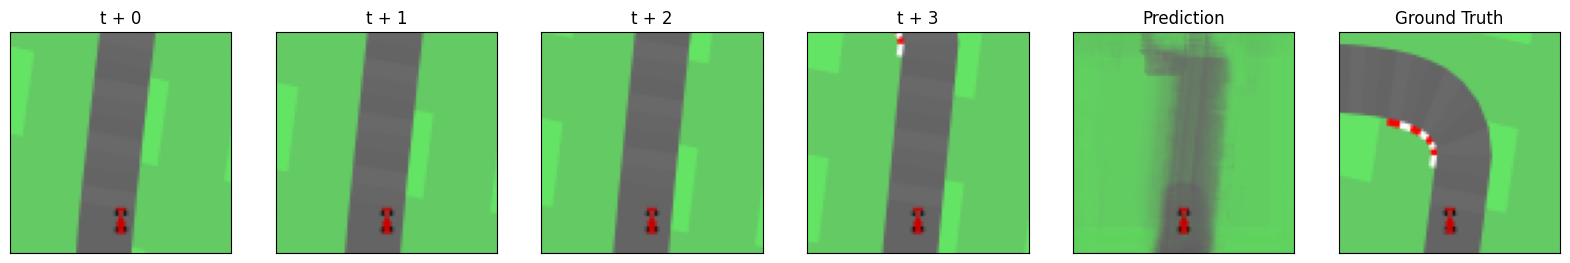

In [29]:
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

idx = np.random.randint(len(test_dataset))
print(idx)

frames, frame_next = test_dataset[idx]

frame_pred = model(frames.unsqueeze(0).to('cuda'))

frames = frames.permute(0, 2, 3, 1).numpy()
frame_next = frame_next.permute(1, 2, 0).numpy()
frame_pred = frame_pred.squeeze().permute(1, 2, 0).cpu().detach().numpy()

for i, ax in enumerate(axs[:-2]):
    ax.imshow(frames[i, :, :, :])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t + {i}")

ax = axs[-2]
ax.imshow(frame_pred)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Prediction")

ax = axs[-1]
ax.imshow(frame_next)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Ground Truth")

plt.show()